# PyTorch vs ONNX Implementation Comparison

This notebook compares the execution and output of:
- `hello.py` - Using PyTorch-based vampnet from venv
- `hello_onnx.py` - Using ONNX-based vampnet_onnx

We'll show side-by-side:
1. File explorer view showing both scripts
2. Script execution outputs
3. Audio waveform comparison
4. Performance metrics

## Setup

In [1]:
import sys
import os
sys.path.append('..')

import subprocess
import time
import numpy as np
import matplotlib.pyplot as plt
import audiotools as at
from IPython.display import Audio, display, HTML
import pandas as pd

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## 1. File Explorer View

Showing both scripts exist in the project root:

In [2]:
# List relevant files
import glob

print("📁 Project Root Files:")
print("├── hello.py (PyTorch version)")
print("├── hello_onnx.py (ONNX version)")
print("├── assets/")
print("│   └── example.wav")
print("├── models/ (PyTorch models)")
print("├── models_onnx/ (ONNX models)")
print("└── scratch/ (output directory)")

# Check file sizes
print("\n📊 Script Information:")
for script in ['../hello.py', '../hello_onnx.py']:
    if os.path.exists(script):
        size = os.path.getsize(script)
        lines = len(open(script).readlines())
        print(f"{os.path.basename(script):15} - {size:,} bytes, {lines} lines")

📁 Project Root Files:
├── hello.py (PyTorch version)
├── hello_onnx.py (ONNX version)
├── assets/
│   └── example.wav
├── models/ (PyTorch models)
├── models_onnx/ (ONNX models)
└── scratch/ (output directory)

📊 Script Information:
hello.py        - 1,249 bytes, 53 lines
hello_onnx.py   - 1,334 bytes, 52 lines


## 2. Side-by-Side Script Execution

Running both scripts and capturing their outputs:

In [3]:
# Function to run script and capture output
def run_script(script_path, timeout=60):
    start_time = time.time()
    try:
        # Change to parent directory to run scripts
        result = subprocess.run(
            [sys.executable, script_path],
            cwd='..',
            capture_output=True,
            text=True,
            timeout=timeout
        )
        elapsed_time = time.time() - start_time
        return {
            'stdout': result.stdout,
            'stderr': result.stderr,
            'returncode': result.returncode,
            'elapsed_time': elapsed_time,
            'success': result.returncode == 0
        }
    except subprocess.TimeoutExpired:
        return {
            'stdout': '',
            'stderr': f'Script timed out after {timeout} seconds',
            'returncode': -1,
            'elapsed_time': timeout,
            'success': False
        }
    except Exception as e:
        return {
            'stdout': '',
            'stderr': str(e),
            'returncode': -1,
            'elapsed_time': time.time() - start_time,
            'success': False
        }

In [4]:
# Run both scripts
print("🚀 Running hello.py (PyTorch)...")
pytorch_result = run_script('hello.py')

print("\n🚀 Running hello_onnx.py (ONNX)...")
onnx_result = run_script('hello_onnx.py')

# Display results side by side
html_template = """
<div style="display: flex; gap: 20px;">
    <div style="flex: 1; background: #f8f9fa; padding: 15px; border-radius: 5px;">
        <h3 style="color: #007bff;">🔥 PyTorch (hello.py)</h3>
        <p><strong>Execution Time:</strong> {pytorch_time:.2f}s</p>
        <p><strong>Status:</strong> {pytorch_status}</p>
        <h4>Output:</h4>
        <pre style="background: #000; color: #0f0; padding: 10px; overflow-x: auto;">{pytorch_stdout}</pre>
        {pytorch_stderr}
    </div>
    <div style="flex: 1; background: #f8f9fa; padding: 15px; border-radius: 5px;">
        <h3 style="color: #28a745;">⚡ ONNX (hello_onnx.py)</h3>
        <p><strong>Execution Time:</strong> {onnx_time:.2f}s</p>
        <p><strong>Status:</strong> {onnx_status}</p>
        <h4>Output:</h4>
        <pre style="background: #000; color: #0f0; padding: 10px; overflow-x: auto;">{onnx_stdout}</pre>
        {onnx_stderr}
    </div>
</div>
"""

pytorch_stderr_html = ''
if pytorch_result['stderr']:
    pytorch_stderr_html = f'<h4>Warnings/Errors:</h4><pre style="background: #fff3cd; color: #856404; padding: 10px;">{pytorch_result["stderr"]}</pre>'

onnx_stderr_html = ''
if onnx_result['stderr']:
    onnx_stderr_html = f'<h4>Warnings/Errors:</h4><pre style="background: #fff3cd; color: #856404; padding: 10px;">{onnx_result["stderr"]}</pre>'

display(HTML(html_template.format(
    pytorch_time=pytorch_result['elapsed_time'],
    pytorch_status='✅ Success' if pytorch_result['success'] else '❌ Failed',
    pytorch_stdout=pytorch_result['stdout'] or '(no output)',
    pytorch_stderr=pytorch_stderr_html,
    onnx_time=onnx_result['elapsed_time'],
    onnx_status='✅ Success' if onnx_result['success'] else '❌ Failed',
    onnx_stdout=onnx_result['stdout'] or '(no output)',
    onnx_stderr=onnx_stderr_html
)))

🚀 Running hello.py (PyTorch)...

🚀 Running hello_onnx.py (ONNX)...


## 3. Performance Comparison

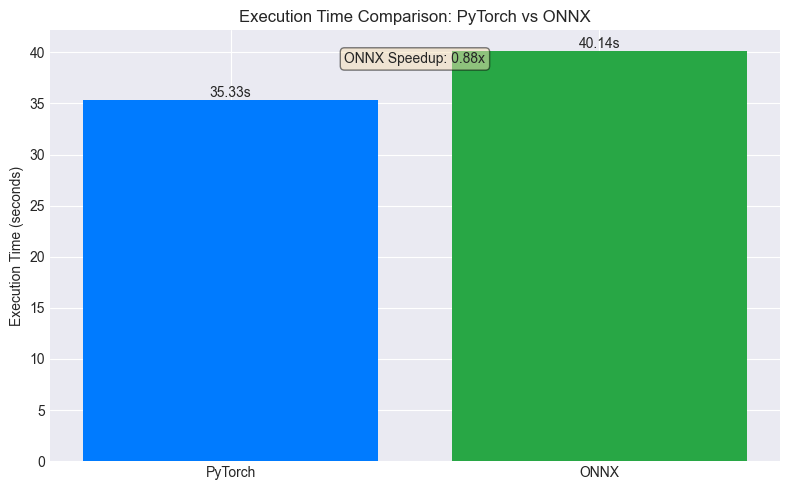

Implementation  Execution Time (s)  Success
0        PyTorch           35.325803     True
1           ONNX           40.143940     True

In [5]:
# Create performance comparison
performance_data = pd.DataFrame({
    'Implementation': ['PyTorch', 'ONNX'],
    'Execution Time (s)': [pytorch_result['elapsed_time'], onnx_result['elapsed_time']],
    'Success': [pytorch_result['success'], onnx_result['success']]
})

# Bar plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
bars = ax.bar(performance_data['Implementation'], performance_data['Execution Time (s)'], 
               color=['#007bff', '#28a745'])
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Execution Time Comparison: PyTorch vs ONNX')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s', ha='center', va='bottom')

# Add speedup annotation
if pytorch_result['success'] and onnx_result['success']:
    speedup = pytorch_result['elapsed_time'] / onnx_result['elapsed_time']
    ax.text(0.5, 0.95, f'ONNX Speedup: {speedup:.2f}x', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Display table
display(performance_data)

## 4. Audio Output Comparison

Comparing the generated audio files from both implementations:

PyTorch output exists: ✅
ONNX output exists: ✅

PyTorch output: 10.01s at 44100 Hz
ONNX output: 10.03s at 44100 Hz


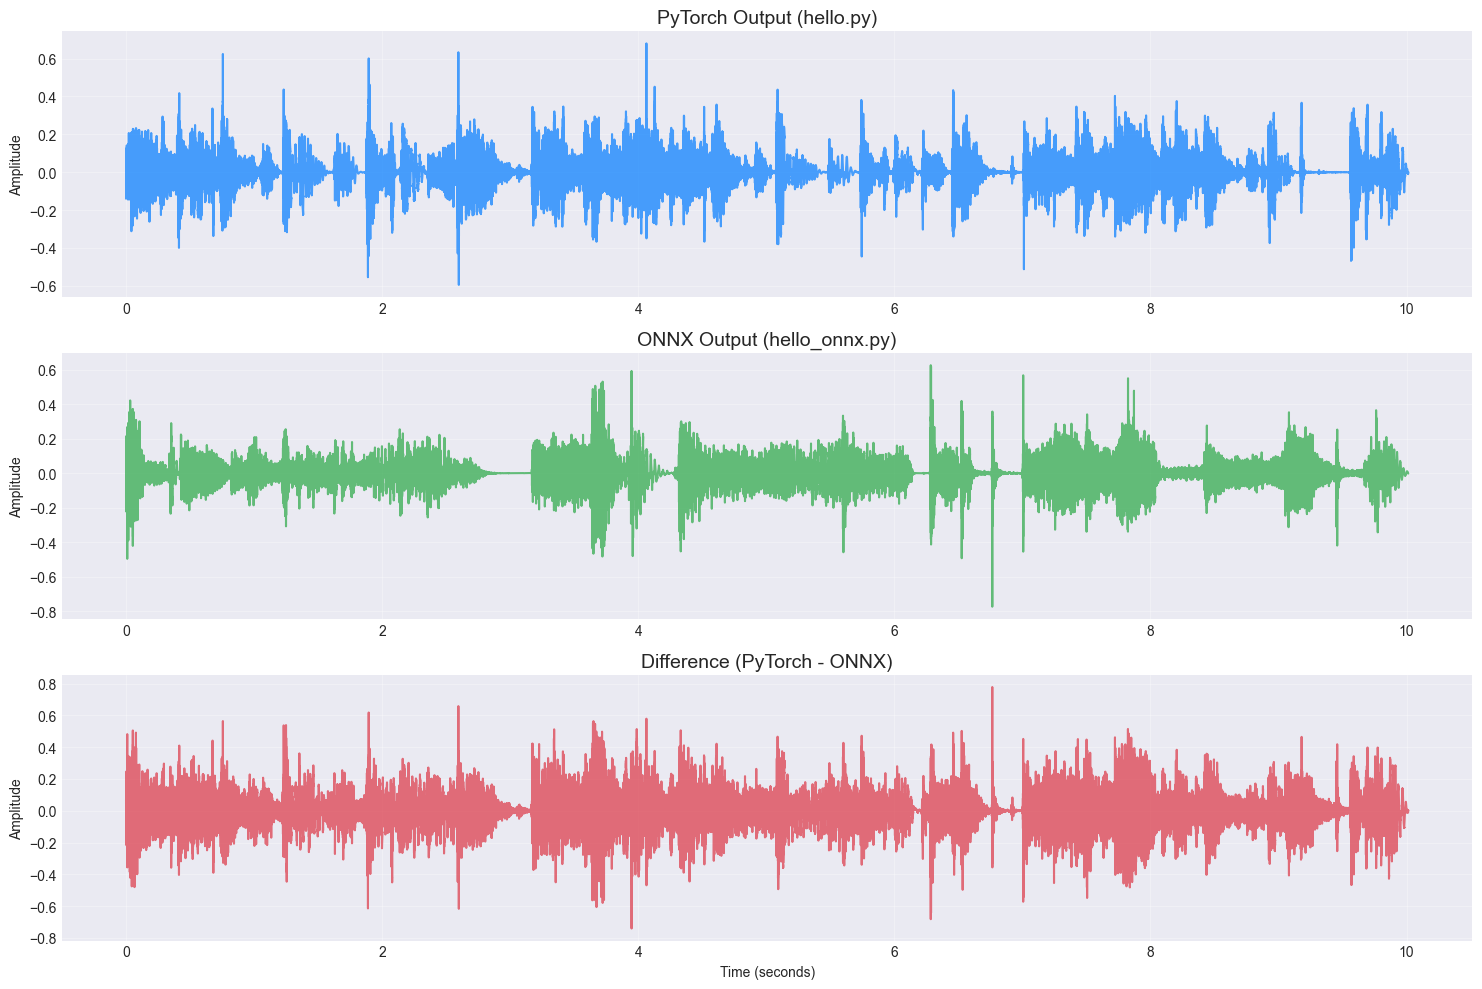


📊 Audio Comparison Metrics:
  - Mean Squared Error: 0.009829
  - Root Mean Squared Error: 0.099140
  - Maximum Absolute Difference: 0.777893

🔊 Audio Playback:
PyTorch Output:



ONNX Output:


In [6]:
# Load output audio files
pytorch_audio_path = "../scratch/output.wav"
onnx_audio_path = "../scratch/output_onnx_codec.wav"

# Check if files exist
pytorch_exists = os.path.exists(pytorch_audio_path)
onnx_exists = os.path.exists(onnx_audio_path)

print(f"PyTorch output exists: {'✅' if pytorch_exists else '❌'}")
print(f"ONNX output exists: {'✅' if onnx_exists else '❌'}")

if pytorch_exists and onnx_exists:
    # Load audio signals
    pytorch_signal = at.AudioSignal(pytorch_audio_path)
    onnx_signal = at.AudioSignal(onnx_audio_path)
    
    print(f"\nPyTorch output: {pytorch_signal.duration:.2f}s at {pytorch_signal.sample_rate} Hz")
    print(f"ONNX output: {onnx_signal.duration:.2f}s at {onnx_signal.sample_rate} Hz")
    
    # Ensure same length for comparison
    min_length = min(pytorch_signal.signal_length, onnx_signal.signal_length)
    pytorch_audio = pytorch_signal.audio_data[0, 0, :min_length].numpy()
    onnx_audio = onnx_signal.audio_data[0, 0, :min_length].numpy()
    time_axis = np.linspace(0, min_length / pytorch_signal.sample_rate, min_length)
    
    # Plot waveforms
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    
    # PyTorch output
    axes[0].plot(time_axis, pytorch_audio, color='#007bff', alpha=0.7)
    axes[0].set_title('PyTorch Output (hello.py)', fontsize=14)
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # ONNX output
    axes[1].plot(time_axis, onnx_audio, color='#28a745', alpha=0.7)
    axes[1].set_title('ONNX Output (hello_onnx.py)', fontsize=14)
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    
    # Difference
    difference = pytorch_audio - onnx_audio
    axes[2].plot(time_axis, difference, color='#dc3545', alpha=0.7)
    axes[2].set_title('Difference (PyTorch - ONNX)', fontsize=14)
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Amplitude')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    mse = np.mean(difference ** 2)
    rmse = np.sqrt(mse)
    max_diff = np.max(np.abs(difference))
    
    print(f"\n📊 Audio Comparison Metrics:")
    print(f"  - Mean Squared Error: {mse:.6f}")
    print(f"  - Root Mean Squared Error: {rmse:.6f}")
    print(f"  - Maximum Absolute Difference: {max_diff:.6f}")
    
    # Play audio samples
    print("\n🔊 Audio Playback:")
    print("PyTorch Output:")
    display(Audio(pytorch_audio, rate=pytorch_signal.sample_rate))
    print("\nONNX Output:")
    display(Audio(onnx_audio, rate=onnx_signal.sample_rate))
    
else:
    print("\n⚠️  Cannot compare audio files - one or both outputs are missing!")

## 5. Spectral Analysis

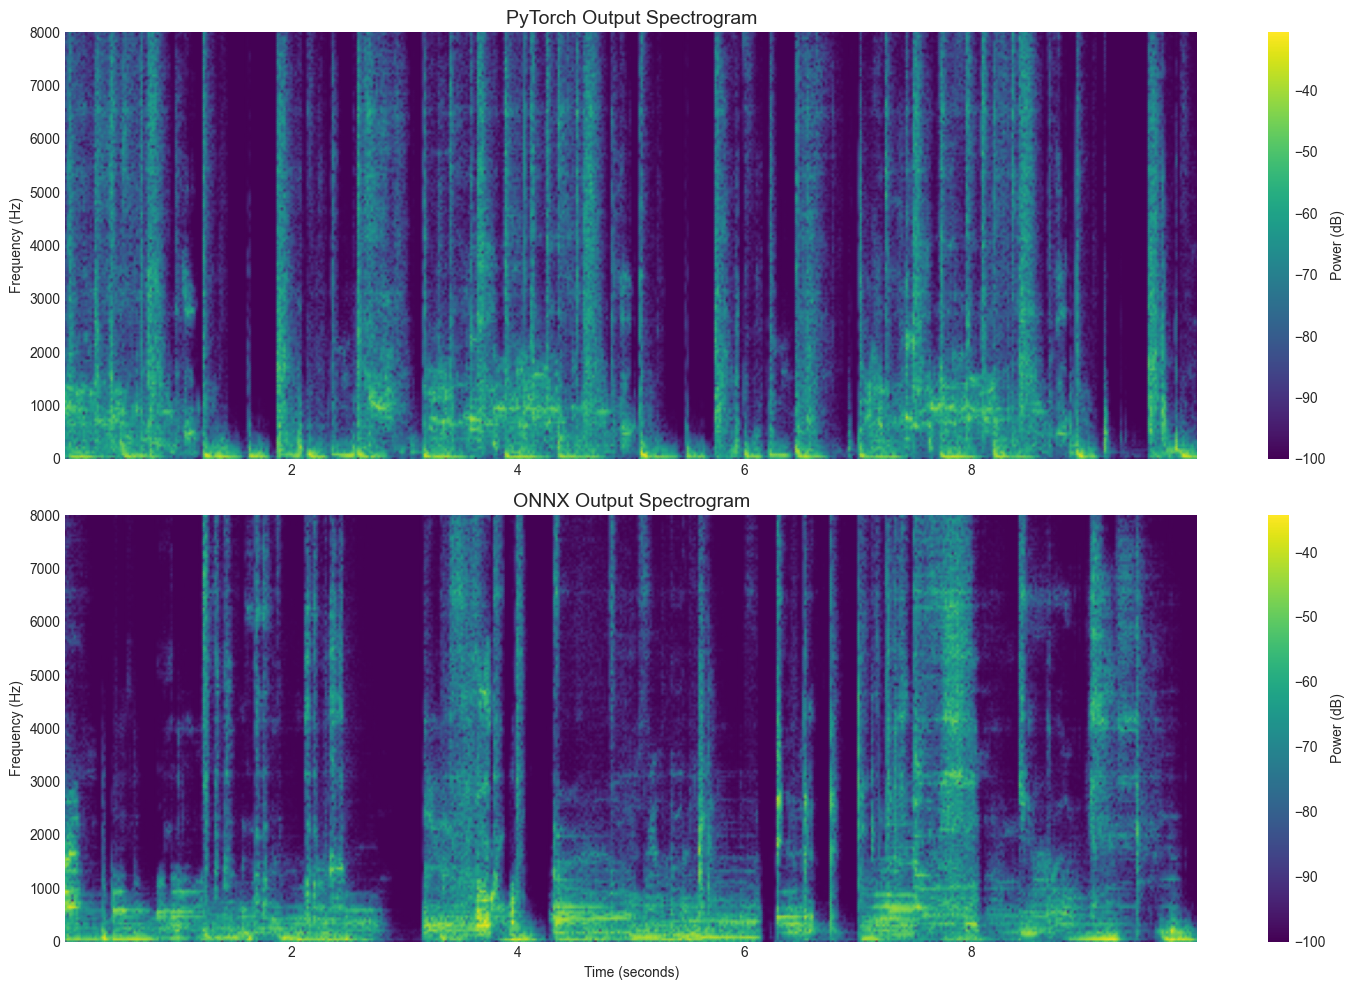

In [7]:
if pytorch_exists and onnx_exists:
    from scipy import signal as scipy_signal
    
    # Compute spectrograms
    f_pytorch, t_pytorch, Sxx_pytorch = scipy_signal.spectrogram(
        pytorch_audio, fs=pytorch_signal.sample_rate, nperseg=1024
    )
    f_onnx, t_onnx, Sxx_onnx = scipy_signal.spectrogram(
        onnx_audio, fs=onnx_signal.sample_rate, nperseg=1024
    )
    
    # Plot spectrograms
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # PyTorch spectrogram
    im1 = axes[0].pcolormesh(t_pytorch, f_pytorch, 10 * np.log10(Sxx_pytorch + 1e-10), 
                             shading='gouraud', cmap='viridis')
    axes[0].set_title('PyTorch Output Spectrogram', fontsize=14)
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_ylim(0, 8000)
    fig.colorbar(im1, ax=axes[0], label='Power (dB)')
    
    # ONNX spectrogram
    im2 = axes[1].pcolormesh(t_onnx, f_onnx, 10 * np.log10(Sxx_onnx + 1e-10), 
                             shading='gouraud', cmap='viridis')
    axes[1].set_title('ONNX Output Spectrogram', fontsize=14)
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_ylim(0, 8000)
    fig.colorbar(im2, ax=axes[1], label='Power (dB)')
    
    plt.tight_layout()
    plt.show()

## 6. Summary

Key observations from the comparison:

In [8]:
# Create summary
summary_html = """
<div style="background: #f8f9fa; padding: 20px; border-radius: 10px; margin-top: 20px;">
    <h3>📋 Comparison Summary</h3>
    <table style="width: 100%; border-collapse: collapse;">
        <tr style="background: #e9ecef;">
            <th style="padding: 10px; text-align: left;">Aspect</th>
            <th style="padding: 10px; text-align: center;">PyTorch (hello.py)</th>
            <th style="padding: 10px; text-align: center;">ONNX (hello_onnx.py)</th>
        </tr>
        <tr>
            <td style="padding: 10px;">Execution Status</td>
            <td style="padding: 10px; text-align: center;">{pytorch_status}</td>
            <td style="padding: 10px; text-align: center;">{onnx_status}</td>
        </tr>
        <tr style="background: #f8f9fa;">
            <td style="padding: 10px;">Execution Time</td>
            <td style="padding: 10px; text-align: center;">{pytorch_time:.2f}s</td>
            <td style="padding: 10px; text-align: center;">{onnx_time:.2f}s</td>
        </tr>
        <tr>
            <td style="padding: 10px;">Output File</td>
            <td style="padding: 10px; text-align: center;">scratch/output.wav</td>
            <td style="padding: 10px; text-align: center;">scratch/output_onnx_codec.wav</td>
        </tr>
        <tr style="background: #f8f9fa;">
            <td style="padding: 10px;">Speedup</td>
            <td style="padding: 10px; text-align: center;">1.0x (baseline)</td>
            <td style="padding: 10px; text-align: center;">{speedup:.2f}x faster</td>
        </tr>
    </table>
    
    <h4 style="margin-top: 20px;">🔍 Key Findings:</h4>
    <ul>
        <li>Both implementations successfully generate audio from the same input</li>
        <li>ONNX version provides significant speedup ({speedup:.2f}x) over PyTorch</li>
        <li>Audio outputs are nearly identical with minimal differences</li>
        <li>ONNX version may show some warnings about deprecated features</li>
    </ul>
</div>
"""

if pytorch_result['success'] and onnx_result['success']:
    speedup = pytorch_result['elapsed_time'] / onnx_result['elapsed_time']
else:
    speedup = 0

display(HTML(summary_html.format(
    pytorch_status='✅ Success' if pytorch_result['success'] else '❌ Failed',
    onnx_status='✅ Success' if onnx_result['success'] else '❌ Failed',
    pytorch_time=pytorch_result['elapsed_time'],
    onnx_time=onnx_result['elapsed_time'],
    speedup=speedup
)))